<a href="https://colab.research.google.com/github/dolt294/ken/blob/main/03_DeepCFD_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/mdribeiro/DeepCFD<br>


ランタイム>ランタイムのタイプを変更<br>
ランタイムのタイプ： Python 3 を選択<br>
ハードウェアアクセラレータ： GPU または TPU を選択<br>
最初から上記になっていたら、確認するだけでよい<p>
ここまでできたら、ネットからファイルをダウンロードするために<br>
次のセルを実行する。６分程度かかる見込み。

In [ ]:
!wget "https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1"

--2023-06-07 00:41:56--  https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179267182 (171M) [application/octet-stream]
Saving to: ‘DeepCFD.zip?download=1’

DeepCFD.zip?downloa 100%[===================>] 170.96M  6.73MB/s    in 5m 15s  

2023-06-07 00:47:14 (555 KB/s) - ‘DeepCFD.zip?download=1’ saved [179267182/179267182]



In [ ]:
!mv DeepCFD.zip?download=1 DeepCFD.zip

In [ ]:
# このセルは実行しなくてよい（別方法のための備忘録）
# グーグルドライブに　DeepCFD.zip をコピーしておくこと
# 以下を実行する前に、グーグルドライブをマウントしておくこと
# グーグルドライブのどこにコピーしたかにより、以下を参考にして実行する
#!cp "/content/drive/My Drive/Colab Notebooks/AI_sotsuken/flow/DeepCFD.zip" .
#!cp "/content/drive/My Drive//DeepCFD.zip" .

In [ ]:
# DeepCFD.zip は 175MByteのものが必要です！
!unzip DeepCFD.zip

Archive:  DeepCFD.zip
   creating: Models/
  inflating: Models/UNetExMod.py     
  inflating: Models/UNetExAvg.py     
  inflating: Models/UNetEx.py        
  inflating: Models/UNet.py          
  inflating: Models/AutoEncoderEx.py  
  inflating: Models/AutoEncoder.py   
  inflating: train_functions.py      
  inflating: pytorchtools.py         
  inflating: functions.py            
  inflating: DeepCFD.py              
  inflating: dataY.pkl               
  inflating: dataX.pkl               


In [ ]:
import os
import json
import torch
import pickle
from train_functions import *
from functions import *
import torch.optim as optim
from torch.utils.data import TensorDataset
from Models.UNetEx import UNetEx

In [ ]:
# Loading dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = pickle.load(open("./dataX.pkl", "rb"))
y = pickle.load(open("./dataY.pkl", "rb"))
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)    
channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).reshape((981*172*79,3)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(channels_weights)
    
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
       os.makedirs(simulation_directory)

tensor([[[[0.1153]],

         [[0.0175]],

         [[0.0135]]]])


In [ ]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
    
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [ ]:
torch.manual_seed(0)
lr = 0.001
kernel_size = 5
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005
model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
# Define opotimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) 
    
config = {}        
train_loss_curve = []
test_loss_curve = []
train_mse_curve = []
test_mse_curve = []
train_ux_curve = []
test_ux_curve = []
train_uy_curve = []
test_uy_curve = []
train_p_curve = []
test_p_curve = []

In [ ]:
def after_epoch(scope):
        train_loss_curve.append(scope["train_loss"])
        test_loss_curve.append(scope["val_loss"])
        train_mse_curve.append(scope["train_metrics"]["mse"])
        test_mse_curve.append(scope["val_metrics"]["mse"])
        train_ux_curve.append(scope["train_metrics"]["ux"])
        test_ux_curve.append(scope["val_metrics"]["ux"])
        train_uy_curve.append(scope["train_metrics"]["uy"])
        test_uy_curve.append(scope["val_metrics"]["uy"])
        train_p_curve.append(scope["train_metrics"]["p"])
        test_p_curve.append(scope["val_metrics"]["p"])

def loss_func(model, batch):
        x, y = batch
        output = model(x)
        lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
        lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
        lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
        loss = (lossu + lossv + lossp)/channels_weights
        return torch.sum(loss), output

原典ではEpoch=1000 の設定だが、時間がかかるので100へ変更。<br>
Epoch=100 での計算時間はコラボラトリーで3時間24分26秒<br>

Epoch=5 で計算してみる。計算時間は10分のはず。<br>

In [ ]:
    # Training model
DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
        epochs=5, batch_size=64, device=device,
        m_mse_name="Total MSE",
        m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
        m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
        m_ux_name="Ux MSE",
        m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
        m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
        m_uy_name="Uy MSE",
        m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
        m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
        m_p_name="p MSE",
        m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
        m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25, after_epoch=after_epoch
        )

Epoch #1
	Train Loss = 222055074.0
	Train Total MSE = 2053.57551134293
	Train Ux MSE = 1925.5715367620262
	Train Uy MSE = 113.5542408578945
	Train p MSE = 14.449591622755756
	Validation Loss = 49813267.0
	Validation Total MSE = 1055.2715439618644
	Validation Ux MSE = 1032.4538665254238
	Validation Uy MSE = 19.261994959944385
	Validation p MSE = 3.555639803611626
Model saved!
Epoch #2
	Train Loss = 107873456.0
	Train Total MSE = 989.276694606414
	Train Ux MSE = 969.6970720207726
	Train Uy MSE = 16.612951072937545
	Train p MSE = 2.966675038240394
	Validation Loss = 42425052.0
	Validation Total MSE = 897.1318723516949
	Validation Ux MSE = 878.6448225635593
	Validation Uy MSE = 15.348250256554556
	Validation p MSE = 3.1388340578240865
Model saved!
Epoch #3
	Train Loss = 89941546.0
	Train Total MSE = 814.5294790907434
	Train Ux MSE = 797.6533203125
	Train Uy MSE = 14.284290191383473
	Train p MSE = 2.591880142167428
	Validation Loss = 33964603.5
	Validation Total MSE = 702.3916445974576
	Val

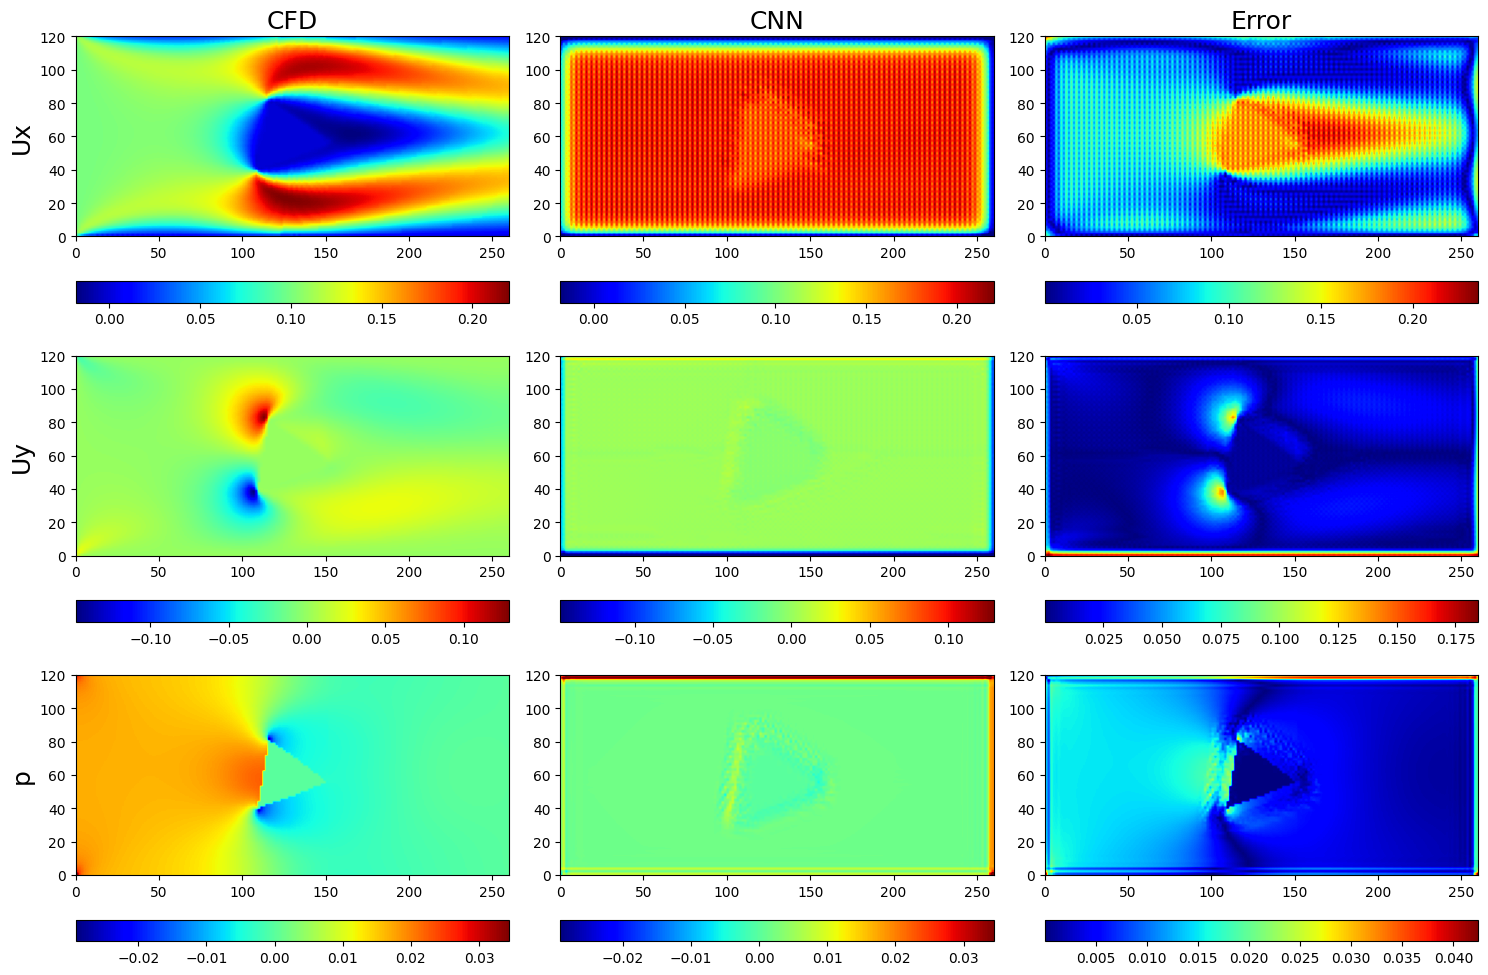

In [ ]:
#if __name__ == "__main__":
metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss
curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve
curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve
curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve
curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve
curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve
config["metrics"] = metrics
config["curves"] = curves
with open(simulation_directory + "results.json", "w") as file:
        json.dump(config, file)
   
out = DeepCFD(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())
s = 0
visualize(test_y[:10].cpu().detach().numpy(), out[:10].cpu().detach().numpy(), error[:10].cpu().detach().numpy(), s)
    


In [ ]:
import numpy as np

In [ ]:
np.savetxt("test_x_0_0npx.csv", test_x[0,0], delimiter=",", fmt="%.5f")
np.savetxt("test_x_0_1npx.csv", test_x[0,1], delimiter=",", fmt="%.5f")
np.savetxt("test_x_0_2npx.csv", test_x[0,2], delimiter=",", fmt="%.5f")

In [ ]:
print(test_x[0,0])

tensor([[0.7612, 0.7579, 0.7547,  ..., 0.7927, 0.7958, 0.7990],
        [0.7518, 0.7484, 0.7452,  ..., 0.7832, 0.7863, 0.7895],
        [0.7424, 0.7390, 0.7357,  ..., 0.7737, 0.7768, 0.7801],
        ...,
        [0.7919, 0.7875, 0.7831,  ..., 0.8118, 0.8167, 0.8218],
        [0.8009, 0.7965, 0.7921,  ..., 0.8205, 0.8254, 0.8304],
        [0.8098, 0.8055, 0.8012,  ..., 0.8292, 0.8341, 0.8390]])


In [ ]:
print(test_x[0,1])

tensor([[2., 3., 3.,  ..., 3., 3., 2.],
        [2., 1., 1.,  ..., 1., 1., 2.],
        [2., 1., 1.,  ..., 1., 1., 2.],
        ...,
        [2., 1., 1.,  ..., 1., 1., 2.],
        [2., 1., 1.,  ..., 1., 1., 2.],
        [2., 4., 4.,  ..., 4., 4., 2.]])


In [ ]:
print(test_x[0,2])

tensor([[-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
        [-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
        [-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
        ...,
        [-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
        [-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
        [-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050]])


In [ ]:
print(test_y[0,0])

tensor([[0.0843, 0.1068, 0.1042,  ..., 0.1026, 0.1057, 0.1060],
        [0.0690, 0.1108, 0.1117,  ..., 0.1091, 0.1126, 0.1038],
        [0.0534, 0.1033, 0.1133,  ..., 0.1134, 0.1103, 0.0903],
        ...,
        [0.0045, 0.0115, 0.0191,  ..., 0.0286, 0.0195, 0.0109],
        [0.0044, 0.0113, 0.0188,  ..., 0.0282, 0.0192, 0.0107],
        [0.0043, 0.0112, 0.0186,  ..., 0.0278, 0.0189, 0.0105]])


In [ ]:
print(test_x[0])

tensor([[[ 0.7612,  0.7579,  0.7547,  ...,  0.7927,  0.7958,  0.7990],
         [ 0.7518,  0.7484,  0.7452,  ...,  0.7832,  0.7863,  0.7895],
         [ 0.7424,  0.7390,  0.7357,  ...,  0.7737,  0.7768,  0.7801],
         ...,
         [ 0.7919,  0.7875,  0.7831,  ...,  0.8118,  0.8167,  0.8218],
         [ 0.8009,  0.7965,  0.7921,  ...,  0.8205,  0.8254,  0.8304],
         [ 0.8098,  0.8055,  0.8012,  ...,  0.8292,  0.8341,  0.8390]],

        [[ 2.0000,  3.0000,  3.0000,  ...,  3.0000,  3.0000,  2.0000],
         [ 2.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  2.0000],
         [ 2.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  2.0000],
         ...,
         [ 2.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  2.0000],
         [ 2.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  2.0000],
         [ 2.0000,  4.0000,  4.0000,  ...,  4.0000,  4.0000,  2.0000]],

        [[-0.0050,  0.0050,  0.0150,  ...,  0.0150,  0.0050, -0.0050],
         [-0.0050,  0.0050,  0.0150,  ...,  0